# important notes
- we need to justify why we are using lumped analysis

# recent changelog
- solar constant derivation added 

##

#### *uncomment and run this cells if you get errors*

In [1]:
# pip install scipy.optimize
# pip install matplotlib 
# pip install numpy

In [2]:
import numpy as np 
import matplotlib.pyplot as plot 
from scipy.optimize import fsolve

## 

# thermals stuff

#### *put all constants in here*

In [3]:
# used for stefan-boltzman calculations
SIGMA = 5.67e-8 # W / m^2 / k

# used for sun heating stuff
SOLAR_INTENSITY = 1360 # W / m^2
SOLAR_SURFACE_TEMP = 5778
SOLAR_EPSILON = 0.999

# general properties
AIR_CP = 1004 # J / kg / k
AIR_DENSITY = 1.29 # kg / m^3
SPACE_TEMPERATURE = 3 # K 
REGOLITH_CONDUCTIVITY = 0.75 # found on the internet 
REGOLITH_DENSITY = 1300 # kg / m^3
REGOLITH_CP = 1400 # J / kg / k

# moon base params
WALL_THICKNESS_COEFF = 0.1 # fraction of sphere radius that is wall 
DOME_EPSILON = 1.0 # we are modeling as a "worst case" blackbody material
DOME_RADII = np.linspace(0.5, 5, 5)
DOME_GUESS_TEMP = 5 # starting temperature guess for the wall temperature 
DOME_INNER_TEMP = 22 # celsius - standard interior temperature 


In [4]:
def point_source_heating(absorptivity, area, intensity):
    return absorptivity * area * intensity

def stefan_boltzmann(epsilon, area, surface_temperature):
    return epsilon * SIGMA * area * surface_temperature**4

def celsius_to_kelvin(temp):
    return temp + 273.15

class ThermalData:
    def __init__(self, radius, thickness, conductivity):
        self.radius = radius
        self.thickness = thickness
        self.conductivity = conductivity
        self.times = []
        self.internal_temperatures = []
        self.surface_temperatures = []
        self.q_dots = []
        self.num_domes = 0
        self.energy_reqs = []

#

# lunar base class

In [5]:
class Wall:
    def __init__(self, thickness, conductivity, absorptivity):
        self.thickness = thickness
        self.conductivity = conductivity
        self.absorptivity = absorptivity

class Sphere:
    def __init__(self, radius, wall):
        self.radius = radius
        self.wall = wall

        self.air_temperature = celsius_to_kelvin(DOME_INNER_TEMP) # placeholder for now
        self.wall_inner_temp = self.air_temperature # approximately the same as the air
        self.wall_outer_temp = DOME_GUESS_TEMP # arbitrary starting value close to the temperature of space 

        self.light_intensity = SOLAR_INTENSITY

        self.reup_temperatures(0)
        return None

    def volume(self):
        return 4 / 3 * np.pi * self.radius**3
    
    def volume_air(self):
        return 4 / 3 * np.pi * (self.radius - self.wall.thickness)**3
    
    def volume_wall(self):
        return self.volume() - self.volume_air()
    
    def mass_air(self):
        return self.volume_air() * AIR_DENSITY
    
    def mass_wall(self):
        return self.volume_wall() * REGOLITH_DENSITY
        
    def surface_area(self):
        return 4 * np.pi * self.radius**2

    def inner_surface_area(self):
        return 4 * np.pi * (self.radius - self.wall.thickness)**2

    def projected_area(self):
        return np.pi * self.radius**2

    def reup_temperatures(self, delta_time):
        self.__reup_internal_temperature(delta_time)
        self.__reup_surface_temperature()
        
    def total_heat_transfer(self):
        heating = point_source_heating(self.wall.absorptivity, self.projected_area(), self.light_intensity)
        cooling = stefan_boltzmann(self.wall.absorptivity, self.surface_area(), self.wall_outer_temp)
        return heating - cooling
    
    def __reup_surface_temperature(self):
        def energy_balance(surface_temperature):
            # this method uses stuff we learned in class
            '''
            '''
            r_sphere = (self.radius - (self.radius - self.wall.thickness)) / (4 * np.pi * self.radius * (self.radius - self.wall.thickness) * self.wall.conductivity)
            q_cond = (self.air_temperature - surface_temperature) / r_sphere
            # this one (the line below) doesn't, but seems to yield a more intuitive result? 
            '''
            q_cond = (self.wall.conductivity / self.wall.thickness) * (self.air_temperature - surface_temperature) * self.inner_surface_area()
            '''
            q_rad = stefan_boltzmann(self.wall.absorptivity, self.surface_area(), surface_temperature)
            return q_cond - q_rad

        temperature_guess = (self.air_temperature + SPACE_TEMPERATURE) / 2 # start by guessing the average temperature
        solution = fsolve(energy_balance, temperature_guess) # use fsolve to find what temperature actually works
        self.wall_outer_temp = solution[0]

    def __reup_internal_temperature(self, delta_time):
        q_net = self.total_heat_transfer()
        thermal_capacity = self.mass_air() * AIR_CP + self.mass_wall() * REGOLITH_CP
        delta_temp = (q_net * delta_time) / thermal_capacity # this is obv just using 1st order integration, we can change this to RK4 later
        self.air_temperature += delta_temp


### this is acting as just a 'hello world' cell, make sure this runs with no errors

In [6]:
# hello world 
sphere = Sphere(1, Wall(0.5, 1, 1))
assert sphere.surface_area() == 4 * np.pi, "make sure this runs"
print("sphere area:", sphere.surface_area())
assert sphere.wall_outer_temp != DOME_GUESS_TEMP
print("calculated surface temperature:", sphere.wall_outer_temp)

sphere area: 12.566370614359172
calculated surface temperature: 201.5621864020656


#

# single dome constant solar radiation

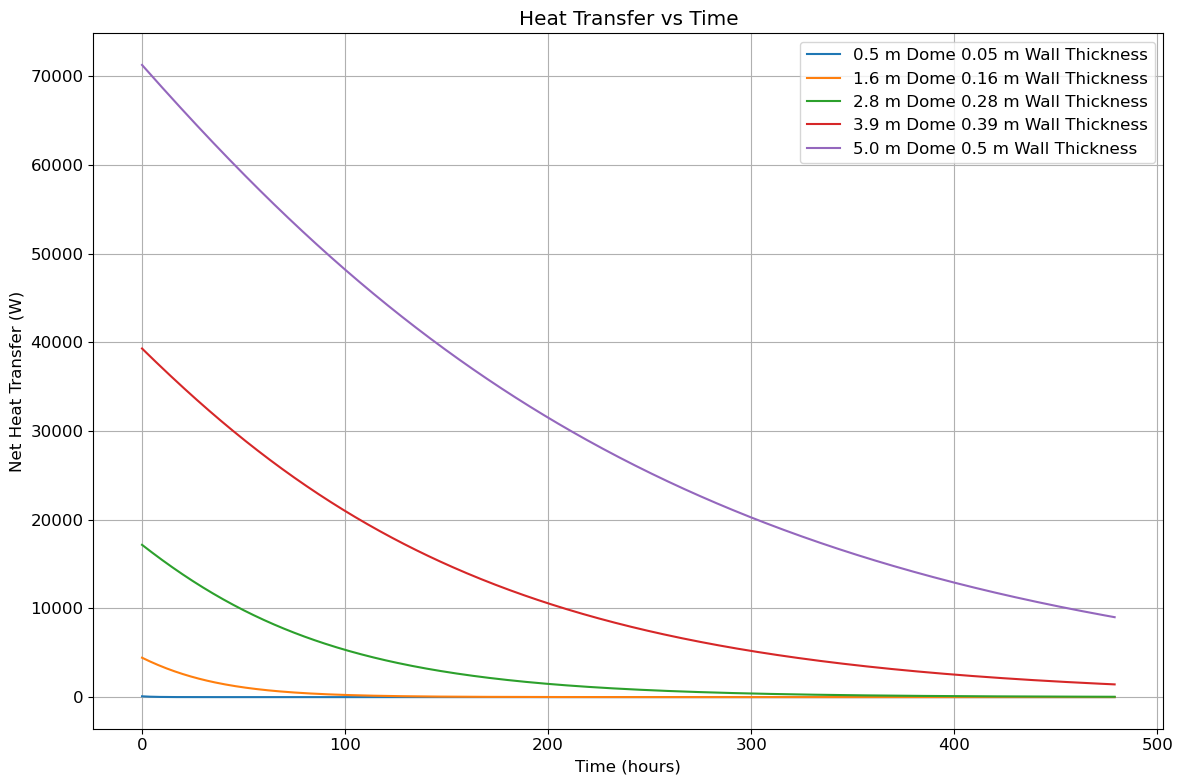

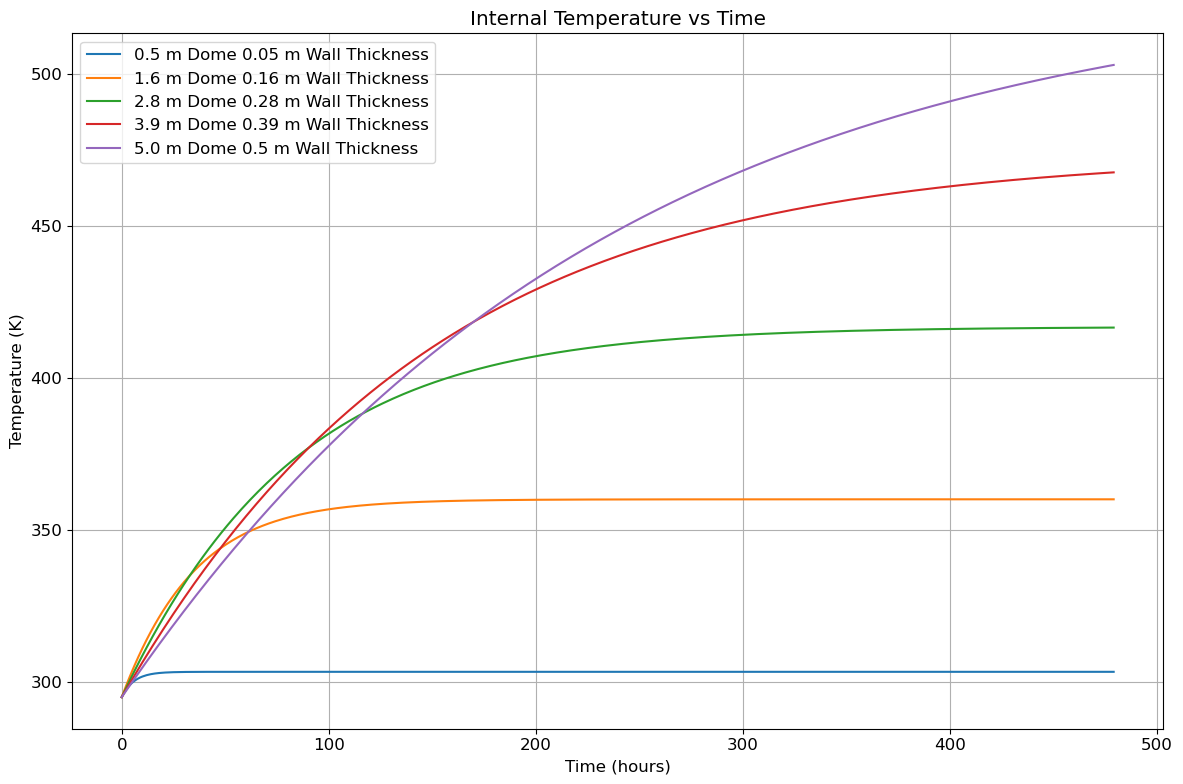

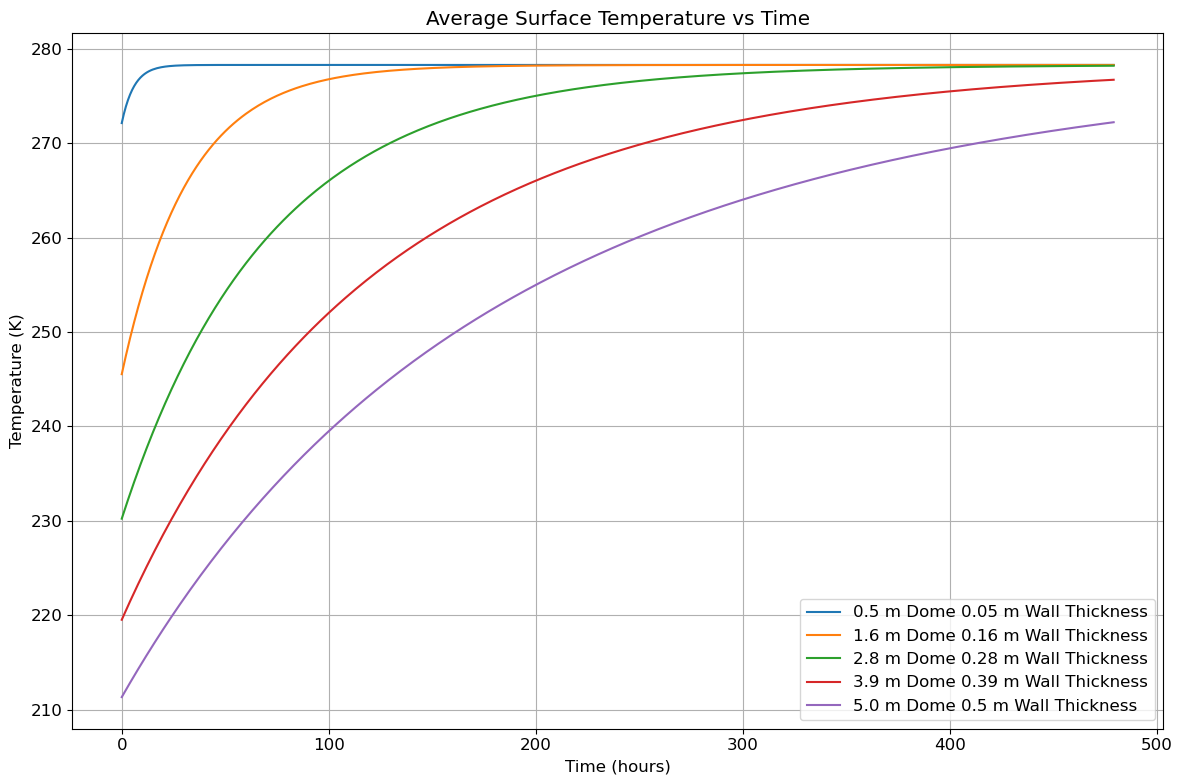

In [7]:
datasets = []

radii = np.linspace(0.5, 5.0, 5)
conductivity = REGOLITH_CONDUCTIVITY
dt = 60 * 60 # hours
duration = 60 * 60 * 24 * 20 # sec -> min -> day -> 20 days 

for radius in radii:
    thickness = radius * WALL_THICKNESS_COEFF
    wall = Wall(thickness, conductivity, DOME_EPSILON)
    sphere = Sphere(radius, wall)
    data = ThermalData(radius, thickness, conductivity)

    for t in range(0, duration, dt):
        data.times.append(t / dt)
        data.internal_temperatures.append(sphere.air_temperature)
        data.surface_temperatures.append(sphere.wall_outer_temp)
        data.q_dots.append(sphere.total_heat_transfer())
        sphere.reup_temperatures(dt)

    datasets.append(data)

# just makes the plot larger with a json 
plot.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 12
})

plot.figure()
for data in datasets:
    plot.plot(data.times, data.q_dots, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Heat Transfer vs Time")
plot.xlabel("Time (hours)")
plot.ylabel("Net Heat Transfer (W)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Internal Temperature vs Time")
plot.xlabel("Time (hours)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.surface_temperatures, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Average Surface Temperature vs Time")
plot.xlabel("Time (hours)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

#

# 2 month (2 lunar days basically) tracking to see more obvious heat is losing during the lunar night

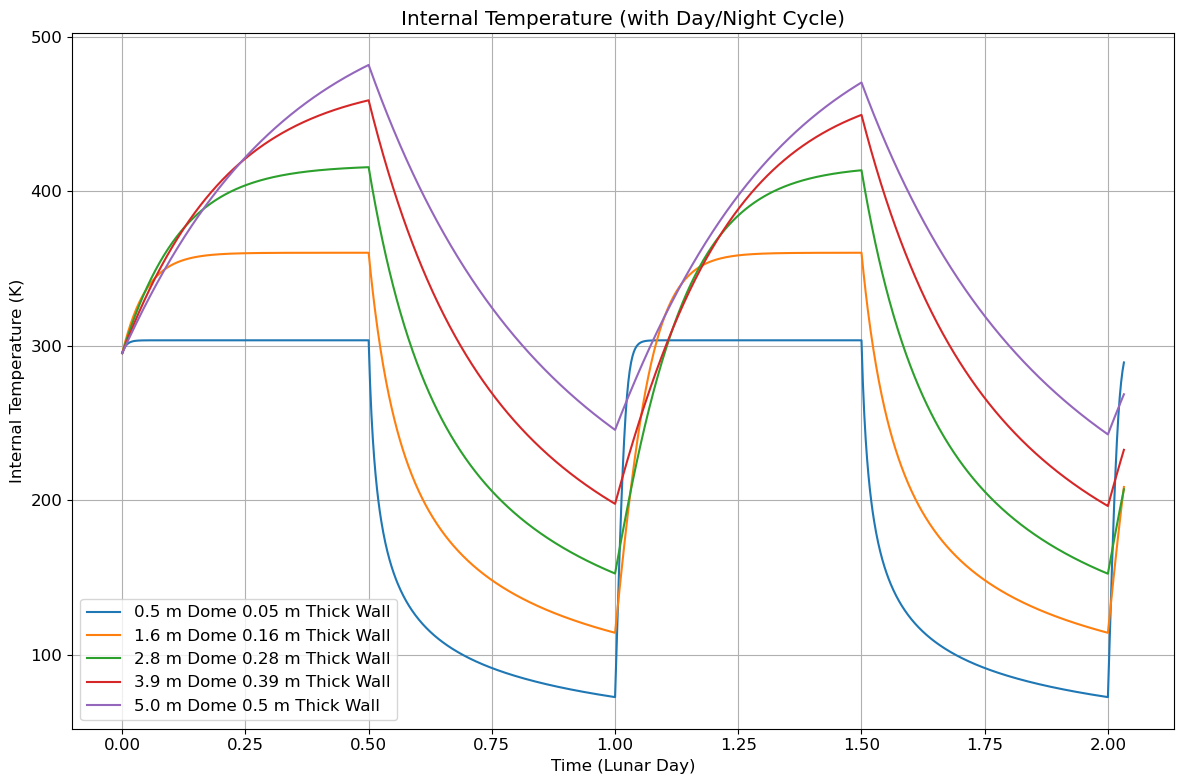

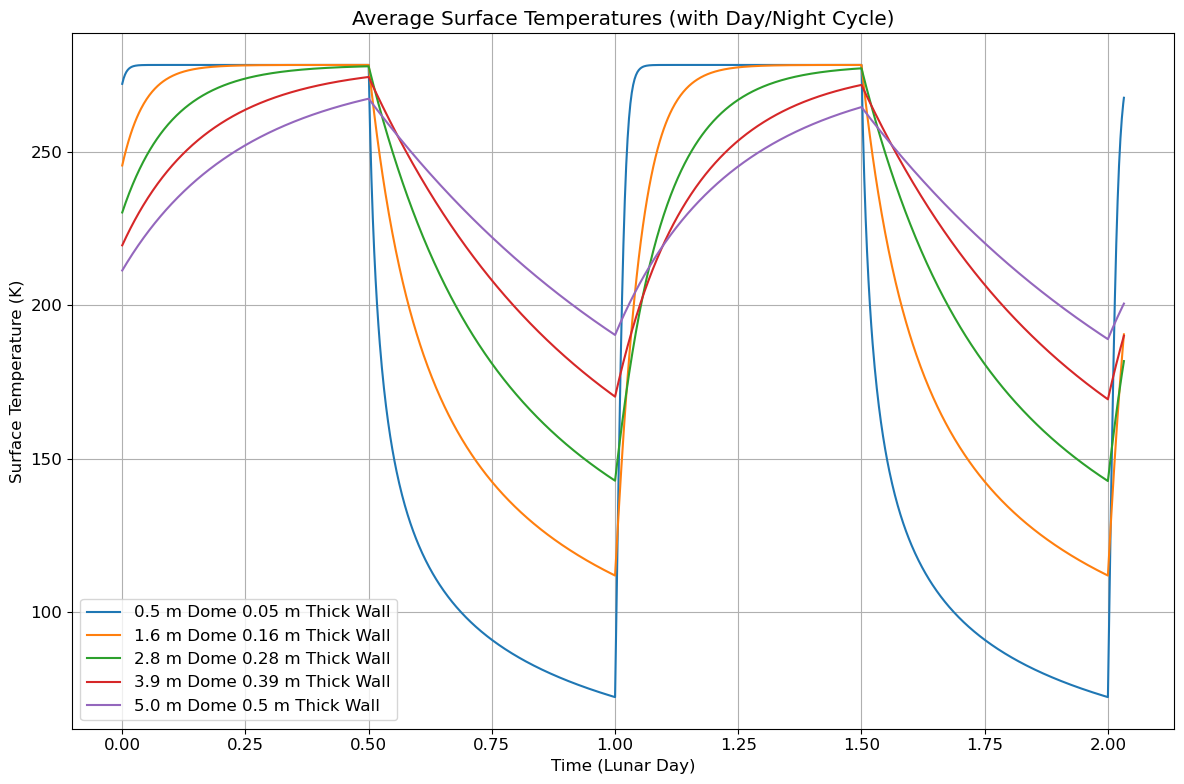

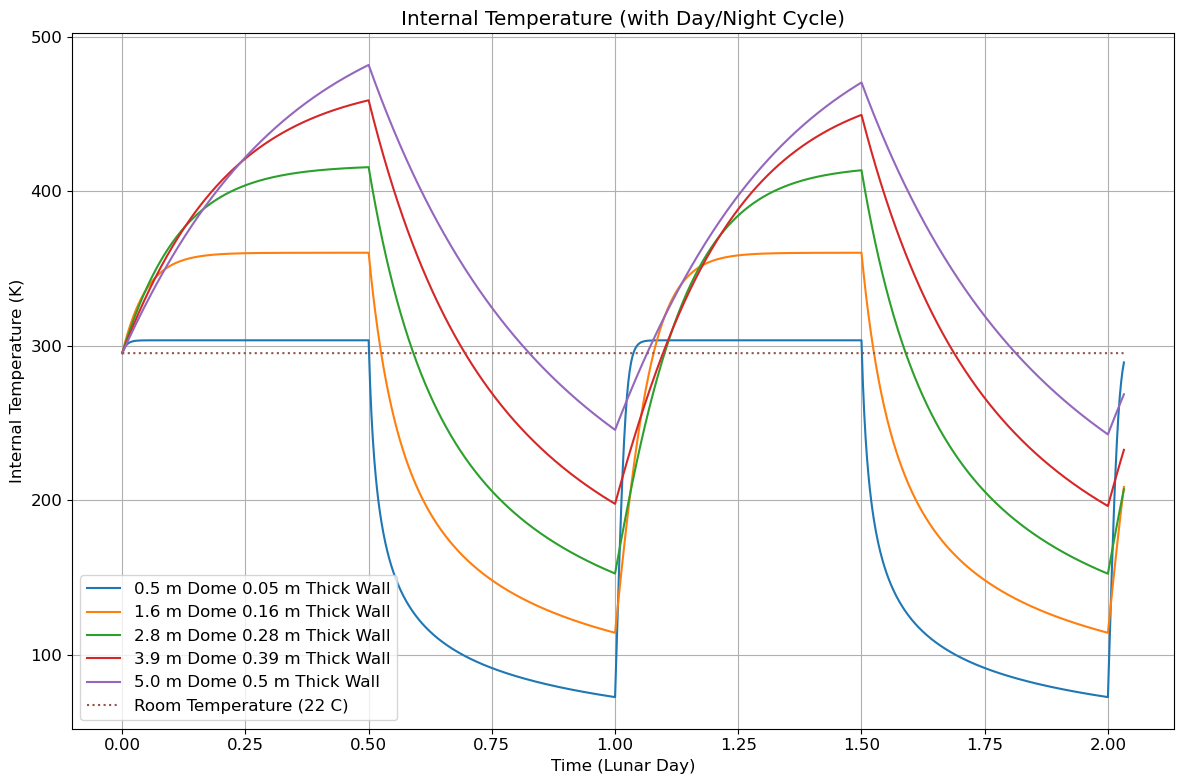

In [8]:
duration = 60 * 60 * 24 * 60 # sec -> min -> day -> 60 days 
dt = 60 * 60 # simultion in first order integration for 1 hour
lunar_day = 60 * 60 * 24 * 29.5
sunlight_hours = 0.5

datasets = []
radii = np.linspace(0.5, 5, 5)
conductivity = REGOLITH_CONDUCTIVITY

for radius in radii:
    thickness = radius * WALL_THICKNESS_COEFF
    wall = Wall(thickness, conductivity, DOME_EPSILON)
    sphere = Sphere(radius, wall)
    data = ThermalData(radius, thickness, conductivity)

    for t in range(0, duration, dt):
        time_in_cycle = t % lunar_day
        is_day: bool = time_in_cycle < (lunar_day * sunlight_hours)
        sphere.light_intensity = SOLAR_INTENSITY if is_day else 0 # basically turns the sun off if it is night

        data.times.append(t / lunar_day)
        data.internal_temperatures.append(sphere.air_temperature)
        data.surface_temperatures.append(sphere.wall_outer_temp)
        data.q_dots.append(sphere.total_heat_transfer())
        sphere.reup_temperatures(dt)

    datasets.append(data)

plot.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 12
})

for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label=f'{data.radius:0.2} m Dome {data.thickness:0.2} m Thick Wall')
plot.title("Internal Temperature (with Day/Night Cycle)")
plot.xlabel("Time (Lunar Day)")
plot.ylabel("Internal Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

for data in datasets:
    plot.plot(data.times, data.surface_temperatures, label=f'{data.radius:0.2} m Dome {data.thickness:0.2} m Thick Wall')
plot.title("Average Surface Temperatures (with Day/Night Cycle)")
plot.xlabel("Time (Lunar Day)")
plot.ylabel("Surface Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label=f'{data.radius:0.2} m Dome {data.thickness:0.2} m Thick Wall')
plot.plot(data.times, np.full_like(data.times, celsius_to_kelvin(DOME_INNER_TEMP)), label=f'Room Temperature (22 C)', linestyle=':')
plot.title("Internal Temperature (with Day/Night Cycle)")
plot.xlabel("Time (Lunar Day)")
plot.ylabel("Internal Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

#

# energy requirements to maintain a livable temperature with multiple domes

In [9]:
class DomeManager:
    def __init__(self, radius, wall, target_volume):
        self.individual_radius = radius
        self.wall = wall
        self.target_volume = target_volume
        self.domes = []
        self.energy = 0

        self.build_to_volume()

    def build_to_volume(self):
        total_air_volume = 0
        while total_air_volume < self.target_volume:
            dome = Sphere(self.individual_radius, self.wall)
            self.domes.append(dome)
            total_air_volume += dome.volume_air()

    def reup_temperatures(self, delta_time):
        for dome in self.domes:
            dome.reup_temperatures(delta_time)

    def total_heat_transfer(self):
        return sum(dome.total_heat_transfer() for dome in self.domes)
    
    def total_energy_requirement(self, delta_time):
        self.energy += self.total_heat_transfer() * delta_time
        return self.energy
    
    def average_air_temperature(self):
        return np.mean([dome.air_temperature for dome in self.domes])
    
    def average_outer_temperature(self):
        return np.mean([dome.wall_outer_temp for dome in self.domes])


In [10]:
fixed_radius = 5
fixed_thickness =  fixed_radius * WALL_THICKNESS_COEFF
fixed_wall = Wall(fixed_thickness, REGOLITH_CONDUCTIVITY, DOME_EPSILON)
fixed_dome = Sphere(fixed_radius, fixed_wall)
target_volume = fixed_dome.volume_air()
print(f'target volume: {target_volume:.2}')

target volume: 3.8e+02


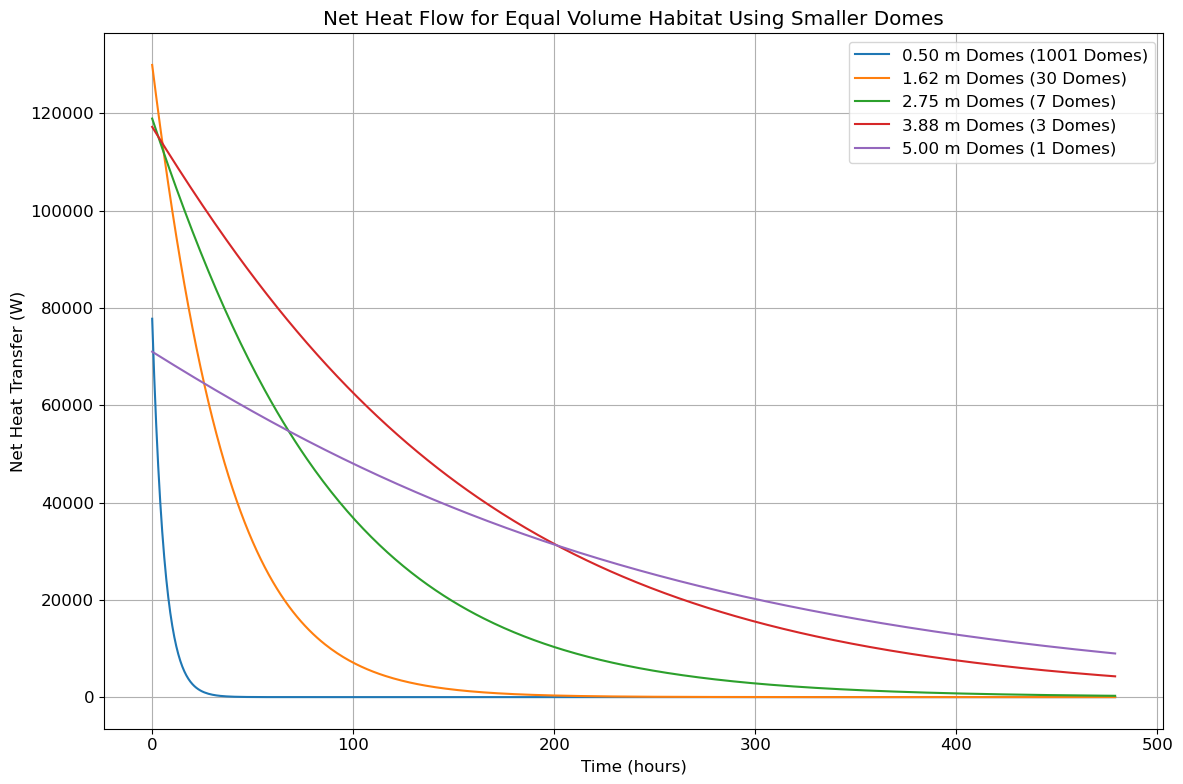

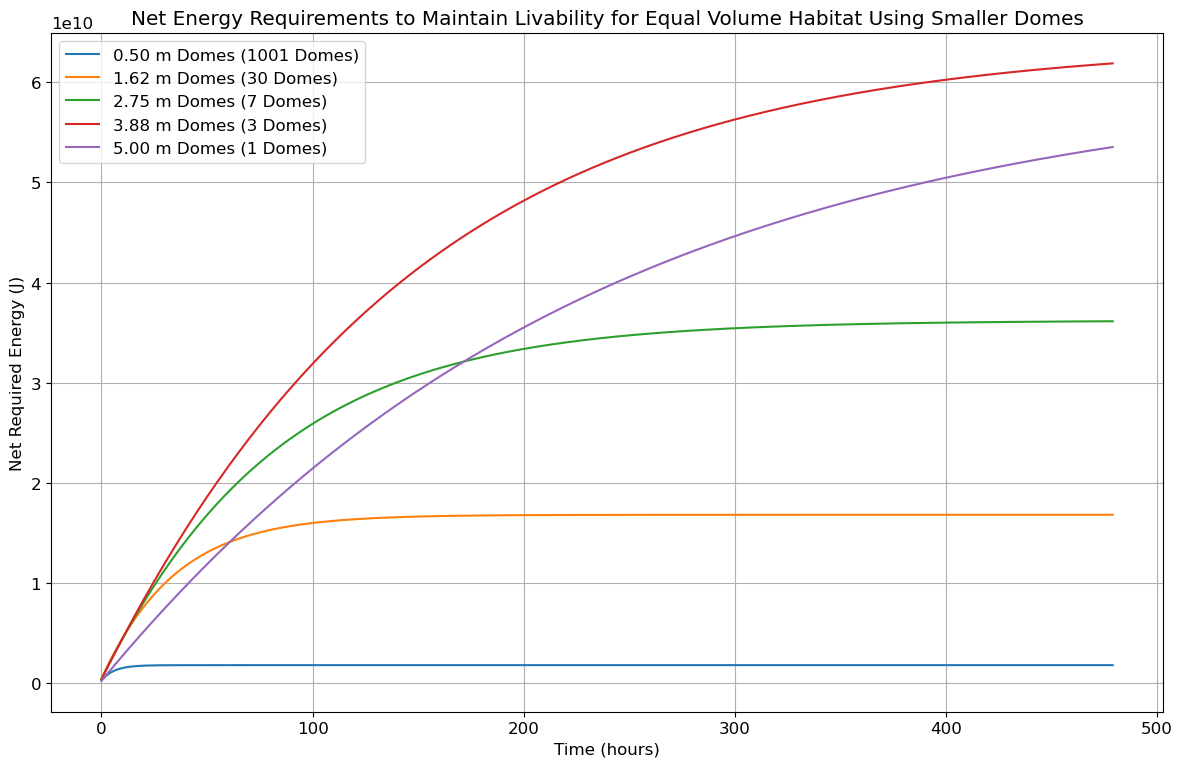

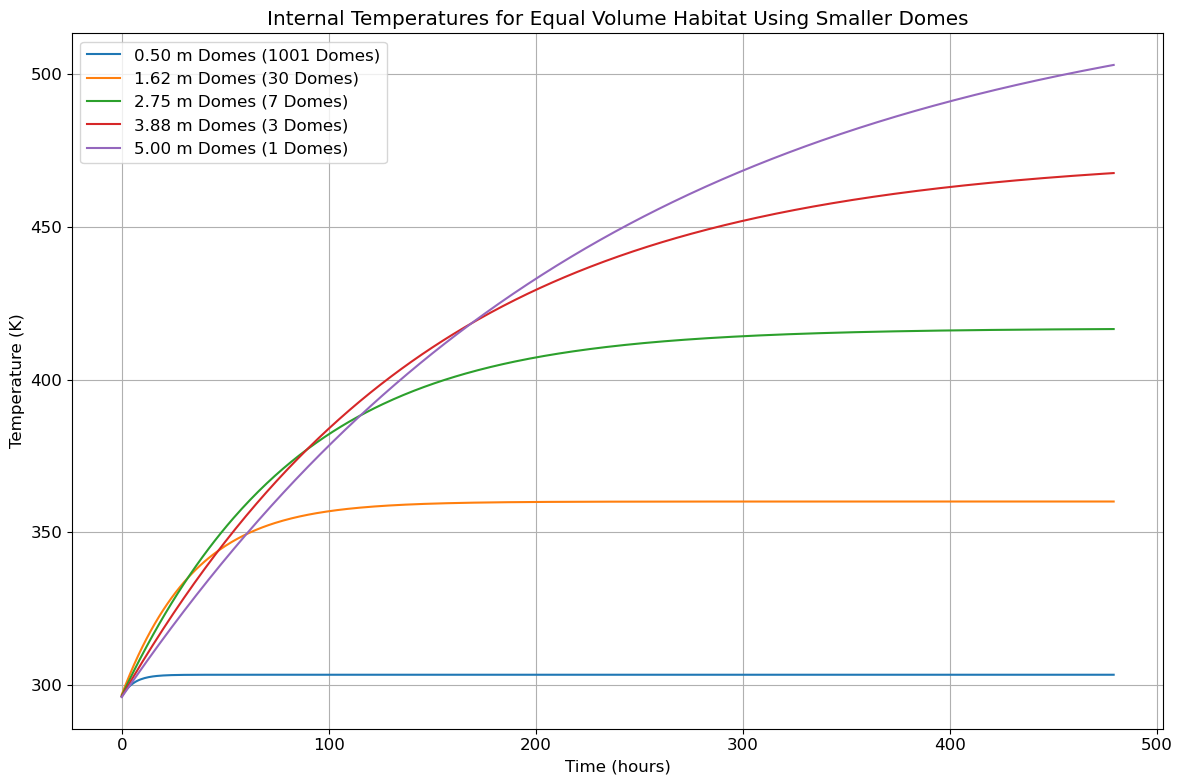

In [11]:
radii = np.linspace(0.5, 5, 5)
datasets = []

dt = 60 * 60 # 1 hour 
duration = 60 * 60 * 24 * 20 # again plotting for 20 days

for radius in radii:
    thickness = radius * WALL_THICKNESS_COEFF
    wall = Wall(thickness, REGOLITH_CONDUCTIVITY, DOME_EPSILON)
    habitat = DomeManager(radius, wall, target_volume)

    data = ThermalData(radius, thickness, REGOLITH_CONDUCTIVITY)

    # this is such a terrible way of doing this but it is really easy
    for t in range(0, duration, dt):
        habitat.reup_temperatures(dt)
        data.times.append(t / dt)
        data.internal_temperatures.append(habitat.average_air_temperature())
        data.surface_temperatures.append(habitat.average_outer_temperature())
        data.q_dots.append(habitat.total_heat_transfer())
        data.num_domes = len(habitat.domes)
        data.energy_reqs.append(habitat.total_energy_requirement(dt))

    datasets.append(data)

plot.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 12
})

plot.figure()
for data in datasets:
    plot.plot(data.times, data.q_dots, label=f'{data.radius:.2f} m Domes ({data.num_domes} Domes)')
plot.title("Net Heat Flow for Equal Volume Habitat Using Smaller Domes")
plot.xlabel("Time (hours)")
plot.ylabel("Net Heat Transfer (W)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.energy_reqs, label=f'{data.radius:.2f} m Domes ({data.num_domes} Domes)')
plot.title("Net Energy Requirements to Maintain Livability for Equal Volume Habitat Using Smaller Domes")
plot.xlabel("Time (hours)")
plot.ylabel("Net Required Energy (J)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label=f'{data.radius:.2f} m Domes ({data.num_domes} Domes)')
plot.title("Internal Temperatures for Equal Volume Habitat Using Smaller Domes")
plot.xlabel("Time (hours)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.tight_layout()
plot.show()

#

# approximation of the solar constant derivation

In [12]:
solar_radius = 696_000_000 # m
astro_unit = 150_000_000_000 # m
solar_epsilon = SOLAR_EPSILON
solar_temperature = SOLAR_SURFACE_TEMP
sun = Sphere(solar_radius, Wall(1, 1, solar_epsilon))
earth_shell = Sphere(astro_unit, Wall(1, 1, DOME_EPSILON))

solar_radiation = stefan_boltzmann(sun.wall.absorptivity, sun.surface_area(), solar_temperature)

solar_constant = solar_radiation / earth_shell.surface_area()

# amazing
print(f'solar constant: {solar_constant}')
assert 1200 < solar_constant and solar_constant < 1500

solar constant: 1359.2353419874648


#

#### just using as a calculator